In [1]:
# dependencies 
import pandas as pd 
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import fatiguelife, mielke, burr, loggamma, gamma, norm, gennorm
from fitter import Fitter, get_common_distributions, get_distributions

import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [2]:
dataset_colors=['pink', 'red', 'orange', 'green', 'teal','blue', 'purple', 'brown']
emotion_color = ['green', 'red', 'orange', 'blue']
emotions = ['positive', 'negative', 'surprise', 'others']
emotions = [emotion.capitalize() for emotion in emotions]
datasets = ['CAS(ME)^2','CASME II', 'MEVIEW','MMEW','SAMM','SMIC_HS','SMIC_NIR','SMIC_VIS']
datasets_label = ['CAS$($ME$)^{2}$','CASME II', 'MEVIEW','MMEW','SAMM','SMIC_HS','SMIC_NIR','SMIC_VIS']

In [3]:
main_data = pd.read_csv('all_micro_annotations.csv')
main_data['dataset'] = main_data['dataset'].replace(['CASME_sq'], 'CAS$($ME$)^{2}$')
main_data['dataset'] = main_data['dataset'].replace(['CASME2'], 'CASME II')
datasets = main_data.dataset.unique().tolist()
datasets.sort()
datasets_apex = main_data[main_data.duration_frame_half > 0].dataset.unique().tolist() # 
emotions = ['positive', 'negative', 'surprise', 'others']

    # Clean 'emotion' column in main_data
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.lower()) # put emotion name into lower case 
main_data = main_data.replace('happy', 'happiness') # combine happiness and happy into happiness only, following terminology used in SMIC_MEAN paper
main_data = main_data.replace('other', 'others') # combine into others only, following terminology used in SMIC_MEAN paper

main_data = main_data.replace(['happiness'], 'positive')
main_data = main_data.replace(['anger', 'fear', 'contempt', 'disgust', 'sadness', 'repression'], 'negative')


# process the raw data for better graphing
emotions = [emotion.capitalize() for emotion in emotions]
main_data['emotion'] = main_data['emotion'].apply(lambda x: x.title())
main_data = main_data.set_index('emotion').loc[emotions].reset_index()

temp = main_data[main_data.duration_time_full <= 0.5]
temp1 = main_data[main_data.duration_time_half > 0]
temp1 = temp1[temp1.duration_time_half <= 0.25]
main_data2 = pd.concat([temp, temp1]).drop_duplicates().reset_index(drop=True)

In [4]:
main_data

,emotion,em,dataset,subject,video,onset,apex,offset,au,type,...,duration_time_full,duration_frame_half,duration_time_half,Inducement Code,Classes,Notes,selfReport,remarks,filename,length
0,Positive,0,CASME II,1,EP02_01f,46,59,86,12,micro-expression,...,0.205000,14,0.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Positive,15,CASME II,2,EP09_01,26,56,125,1+12,micro-expression,...,0.500000,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Positive,35,CASME II,5,EP03_01,41,81,101,14,micro-expression,...,0.305000,41,0.205000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Positive,53,CASME II,6,EP01_01,81,111,136,L14+L15,micro-expression,...,0.280000,31,0.155000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Positive,70,CASME II,9,EP02_01f,21,74,91,L12,micro-expression,...,0.355000,54,0.270000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Others,292,MMEW,30,S30-04-001,1,15,33,L4,micro-expression,...,0.366667,15,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,Others,293,MMEW,30,S30-04-002,1,20,45,4,micro-expression,...,0.500000,20,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,Others,294,MMEW,30,S30-04-003,1,17,48,4,micro-expression,...,0.533333,17,0.188889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,Others,295,MMEW,30,S30-04-004,1,13,31,4,micro-expression,...,0.344444,13,0.144444,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
casme2 = main_data[main_data.dataset=='CASME2']
casme_sq = main_data[main_data.dataset=='CAS$($ME$)^{2}$']
meview = main_data[main_data.dataset=='MEVIEW']
mmew = main_data[main_data.dataset=='MMEW']
samm = main_data[main_data.dataset=='SAMM']
smic_hs = main_data[main_data.dataset=='SMIC_HS']
smic_vis = main_data[main_data.dataset=='SMIC_VIS']
smic_nir = main_data[main_data.dataset=='SMIC_NIR']

### Segment raw data by conditions

### Summary Statistics: ME Duration

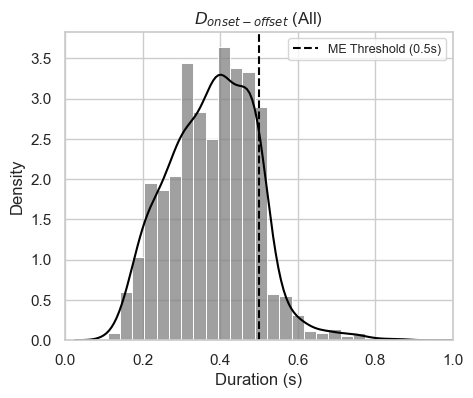

,count,mean,std,min,25%,50%,75%,max
duration_time_full,1102.0,0.381187,0.114433,0.11,0.3,0.388889,0.466667,1.28


duration_time_full                                          \
                             count      mean       std       min       25%   
dataset                                                                      
CAS$($ME$)^{2}$               57.0  0.452632  0.066353  0.300000  0.433333   
CASME II                     255.0  0.336039  0.113039  0.120000  0.255000   
MEVIEW                        25.0  0.518400  0.211181  0.200000  0.400000   
MMEW                         300.0  0.421778  0.112253  0.155556  0.344444   
SAMM                         159.0  0.371855  0.094999  0.150000  0.297500   
SMIC_HS                      164.0  0.337317  0.092472  0.110000  0.267500   
SMIC_NIR                      71.0  0.384789  0.091055  0.160000  0.320000   
SMIC_VIS                      71.0  0.384789  0.091055  0.160000  0.320000   

                                               
                      50%       75%       max  
dataset                                        
CAS$($ME$)^{2}$  0.466667  0.500000  0.566667  
CASME II         0.305000  0.430000  0.705000  
MEVIEW           0.480000  0.600000  1.280000  
MMEW             0.422222  0.488889  0.855556  
SAMM             0.390000  0.447500  0.505000  
SMIC_HS          0.330000  0.410000  0.580000  
SMIC_NIR         0.400000  0.440000  0.520000  
SMIC_VIS         0.400000  0.440000  0.520000

duration_time_full                                \
                                      count      mean       std       min   
dataset         emotion                                                     
CAS$($ME$)^{2}$ Negative               21.0  0.442857  0.070034  0.300000   
                Others                 19.0  0.463158  0.064688  0.300000   
                Positive                8.0  0.475000  0.061075  0.366667   
                Surprise                9.0  0.433333  0.066667  0.300000   
CASME II        Negative               99.0  0.343737  0.114674  0.155000   
                Others                 99.0  0.321566  0.116548  0.120000   
                Positive               32.0  0.368750  0.104866  0.155000   
                Surprise               25.0  0.321000  0.095361  0.180000   
MEVIEW          Negative               12.0  0.546667  0.276778  0.200000   
                Positive                6.0  0.540000  0.159499  0.320000   
                Surprise                7.0  0.451429  0.097199  0.320000   
MMEW            Negative              109.0  0.426402  0.110728  0.155556   
                Others                 66.0  0.396296  0.106758  0.200000   
                Positive               36.0  0.388580  0.095968  0.166667   
                Surprise               89.0  0.448439  0.118329  0.166667   
SAMM            Negative               92.0  0.364022  0.094614  0.150000   
                Others                 26.0  0.409231  0.087746  0.170000   
                Positive               26.0  0.372500  0.099582  0.175000   
                Surprise               15.0  0.354000  0.094173  0.205000   
SMIC_HS         Negative               70.0  0.316714  0.093989  0.110000   
                Positive               51.0  0.362745  0.094743  0.160000   
                Surprise               43.0  0.340698  0.080516  0.200000   
SMIC_NIR        Negative               23.0  0.353043  0.108980  0.160000   
                Positive               28.0  0.415714  0.078004  0.240000   
                Surprise               20.0  0.378000  0.073956  0.240000   
SMIC_VIS        Negative               23.0  0.353043  0.108980  0.160000   
                Positive               28.0  0.415714  0.078004  0.240000   
                Surprise               20.0  0.378000  0.073956  0.240000   

                                                                  
                               25%       50%       75%       max  
dataset         emotion                                           
CAS$($ME$)^{2}$ Negative  0.433333  0.433333  0.500000  0.566667  
                Others    0.433333  0.466667  0.516667  0.533333  
                Positive  0.433333  0.483333  0.533333  0.533333  
                Surprise  0.400000  0.466667  0.466667  0.500000  
CASME II        Negative  0.255000  0.330000  0.430000  0.630000  
                Others    0.230000  0.305000  0.387500  0.705000  
                Positive  0.298750  0.402500  0.456250  0.500000  
                Surprise  0.255000  0.280000  0.405000  0.500000  
MEVIEW          Negative  0.390000  0.460000  0.620000  1.280000  
                Positive  0.460000  0.520000  0.640000  0.760000  
                Surprise  0.380000  0.480000  0.500000  0.600000  
MMEW            Negative  0.355556  0.433333  0.488889  0.800000  
                Others    0.325000  0.394444  0.466667  0.733333  
                Positive  0.338889  0.400000  0.458333  0.555556  
                Surprise  0.388889  0.466667  0.511111  0.855556  
SAMM            Negative  0.290000  0.382500  0.445000  0.500000  
                Others    0.376250  0.435000  0.476250  0.500000  
                Positive  0.297500  0.387500  0.463750  0.505000  
                Surprise  0.265000  0.385000  0.435000  0.470000  
SMIC_HS         Negative  0.242500  0.310000  0.380000  0.580000  
                Positive  0.290000  0.360000  0.450000  0.500000  
                Surprise  0.2

In [6]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))
plot = sns.histplot(data=main_data, x="duration_time_full", stat='density', color="grey", ax=ax1).set_title("$D_{onset-offset}$ (All)")
sns.kdeplot(data=main_data, x='duration_time_full', color="black", ax=ax1)
ax1.set_xlabel("Duration (s)"), ax1.set_xlim([0, 1])
ax1.axvline(x=0.5, color='black', ls='--', label='ME Threshold (0.5s)')
ax1.legend(loc="upper right", fontsize=9)
plt.show()

display(main_data[['duration_time_full']].describe().T)
display(main_data[['duration_time_full', 'dataset']].groupby('dataset').describe())
display(main_data[['duration_time_full', 'dataset', 'emotion']].groupby(['dataset', 'emotion']).describe())

# Filter ME durations that are within 0.5 seconds

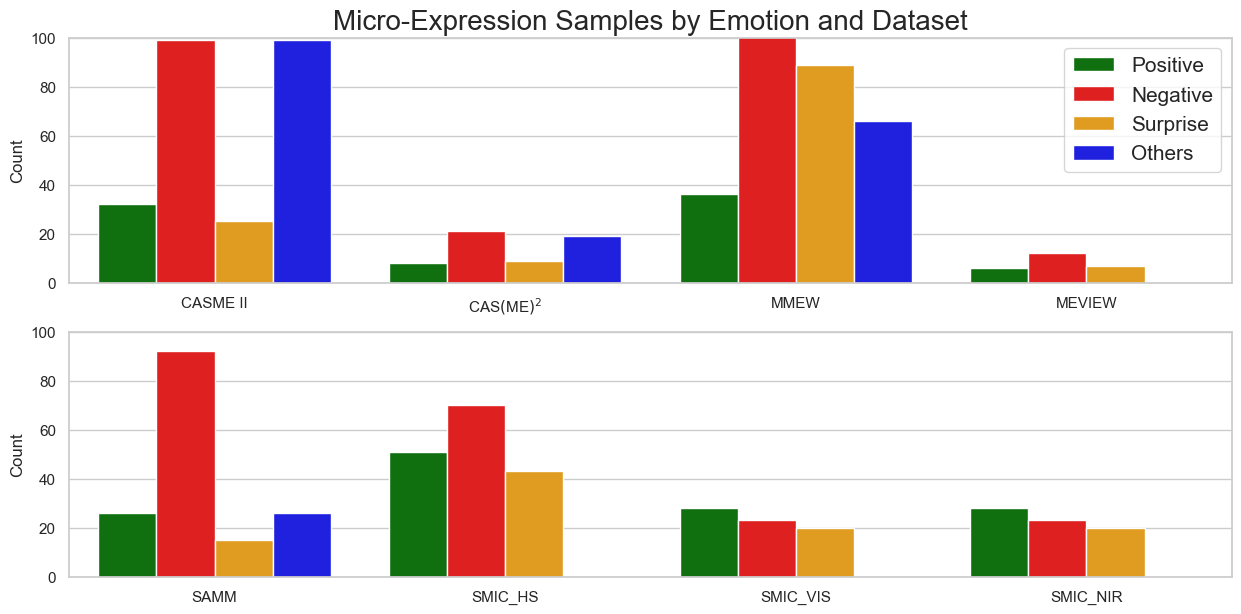

In [7]:
filtered_data1 = main_data[(main_data.dataset==datasets[0])|(main_data.dataset==datasets[1])|(main_data.dataset==datasets[2])|(main_data.dataset==datasets[3])]
filtered_data2 = main_data[(main_data.dataset==datasets[4])|(main_data.dataset==datasets[5])|(main_data.dataset==datasets[6])|(main_data.dataset==datasets[7])]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))

sns.countplot(data=filtered_data1, x="dataset", hue="emotion", palette =emotion_color, ax=ax1).set_title('Micro-Expression Samples by Emotion and Dataset', fontsize=20)
sns.countplot(data=filtered_data2, x="dataset", hue="emotion", palette =emotion_color, ax=ax2)
ax1.set_xlabel(""), ax2.set_xlabel("")
ax1.set_ylabel("Count"), ax2.set_ylabel("Count")
ax1.set_ylim([0, 100]), ax2.set_ylim([0, 100])
ax1.legend(title="", fontsize=15), ax2.legend([], [], frameon=False)
plt.savefig('0 - ME samples by dataset and emotion', bbox_inches='tight', dpi=400)
plt.show()

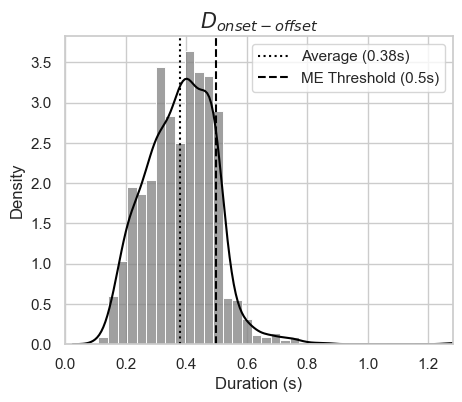

,count,mean,std,min,25%,50%,75%,max
duration_time_full,1102.0,0.381187,0.114433,0.11,0.3,0.388889,0.466667,1.28


duration_time_full                                          \
                             count      mean       std       min       25%   
dataset                                                                      
CAS$($ME$)^{2}$               57.0  0.452632  0.066353  0.300000  0.433333   
CASME II                     255.0  0.336039  0.113039  0.120000  0.255000   
MEVIEW                        25.0  0.518400  0.211181  0.200000  0.400000   
MMEW                         300.0  0.421778  0.112253  0.155556  0.344444   
SAMM                         159.0  0.371855  0.094999  0.150000  0.297500   
SMIC_HS                      164.0  0.337317  0.092472  0.110000  0.267500   
SMIC_NIR                      71.0  0.384789  0.091055  0.160000  0.320000   
SMIC_VIS                      71.0  0.384789  0.091055  0.160000  0.320000   

                                               
                      50%       75%       max  
dataset                                        
CAS$($ME$)^{2}$  0.466667  0.500000  0.566667  
CASME II         0.305000  0.430000  0.705000  
MEVIEW           0.480000  0.600000  1.280000  
MMEW             0.422222  0.488889  0.855556  
SAMM             0.390000  0.447500  0.505000  
SMIC_HS          0.330000  0.410000  0.580000  
SMIC_NIR         0.400000  0.440000  0.520000  
SMIC_VIS         0.400000  0.440000  0.520000

duration_time_full                                \
                                      count      mean       std       min   
dataset         emotion                                                     
CAS$($ME$)^{2}$ Negative               21.0  0.442857  0.070034  0.300000   
                Others                 19.0  0.463158  0.064688  0.300000   
                Positive                8.0  0.475000  0.061075  0.366667   
                Surprise                9.0  0.433333  0.066667  0.300000   
CASME II        Negative               99.0  0.343737  0.114674  0.155000   
                Others                 99.0  0.321566  0.116548  0.120000   
                Positive               32.0  0.368750  0.104866  0.155000   
                Surprise               25.0  0.321000  0.095361  0.180000   
MEVIEW          Negative               12.0  0.546667  0.276778  0.200000   
                Positive                6.0  0.540000  0.159499  0.320000   
                Surprise                7.0  0.451429  0.097199  0.320000   
MMEW            Negative              109.0  0.426402  0.110728  0.155556   
                Others                 66.0  0.396296  0.106758  0.200000   
                Positive               36.0  0.388580  0.095968  0.166667   
                Surprise               89.0  0.448439  0.118329  0.166667   
SAMM            Negative               92.0  0.364022  0.094614  0.150000   
                Others                 26.0  0.409231  0.087746  0.170000   
                Positive               26.0  0.372500  0.099582  0.175000   
                Surprise               15.0  0.354000  0.094173  0.205000   
SMIC_HS         Negative               70.0  0.316714  0.093989  0.110000   
                Positive               51.0  0.362745  0.094743  0.160000   
                Surprise               43.0  0.340698  0.080516  0.200000   
SMIC_NIR        Negative               23.0  0.353043  0.108980  0.160000   
                Positive               28.0  0.415714  0.078004  0.240000   
                Surprise               20.0  0.378000  0.073956  0.240000   
SMIC_VIS        Negative               23.0  0.353043  0.108980  0.160000   
                Positive               28.0  0.415714  0.078004  0.240000   
                Surprise               20.0  0.378000  0.073956  0.240000   

                                                                  
                               25%       50%       75%       max  
dataset         emotion                                           
CAS$($ME$)^{2}$ Negative  0.433333  0.433333  0.500000  0.566667  
                Others    0.433333  0.466667  0.516667  0.533333  
                Positive  0.433333  0.483333  0.533333  0.533333  
                Surprise  0.400000  0.466667  0.466667  0.500000  
CASME II        Negative  0.255000  0.330000  0.430000  0.630000  
                Others    0.230000  0.305000  0.387500  0.705000  
                Positive  0.298750  0.402500  0.456250  0.500000  
                Surprise  0.255000  0.280000  0.405000  0.500000  
MEVIEW          Negative  0.390000  0.460000  0.620000  1.280000  
                Positive  0.460000  0.520000  0.640000  0.760000  
                Surprise  0.380000  0.480000  0.500000  0.600000  
MMEW            Negative  0.355556  0.433333  0.488889  0.800000  
                Others    0.325000  0.394444  0.466667  0.733333  
                Positive  0.338889  0.400000  0.458333  0.555556  
                Surprise  0.388889  0.466667  0.511111  0.855556  
SAMM            Negative  0.290000  0.382500  0.445000  0.500000  
                Others    0.376250  0.435000  0.476250  0.500000  
                Positive  0.297500  0.387500  0.463750  0.505000  
                Surprise  0.265000  0.385000  0.435000  0.470000  
SMIC_HS         Negative  0.242500  0.310000  0.380000  0.580000  
                Positive  0.290000  0.360000  0.450000  0.500000  
                Surprise  0.2

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot = sns.histplot(data=main_data, x="duration_time_full", stat='density',color="grey", ax=ax).set_title("$D_{onset-offset}$", fontsize=15)
sns.kdeplot(data=main_data, x='duration_time_full', color="black")
ax.set_xlabel("Duration (s)"), ax.set_xlim([0, np.max(main_data["duration_time_full"])])
ax.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='dotted', label=f"Average ({np.mean(main_data['duration_time_full']):.2f}s)")
ax.axvline(x=0.5, color='black', ls='--', label='ME Threshold (0.5s)')
ax.legend()
plt.savefig('1-Microexpression Duration.png', bbox_inches='tight', dpi=400)
plt.show()

display(main_data[['duration_time_full']].describe().T)
temp=main_data[['duration_time_full']].describe().T
display(main_data[['duration_time_full', 'dataset']].groupby('dataset').describe())
display(main_data[['duration_time_full', 'dataset', 'emotion']].groupby(['dataset', 'emotion']).describe())

### Fitting known distributions 

In [9]:
#Code used to find best fitting distributions
duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
duration_fit = main_data['duration_time_full'].values
f = Fitter(duration_fit, distributions=duration_dist, timeout=300)
f.fit()
f.summary(plot=False)

Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.86it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,27.250014,674.878338,-4049.190870,inf,0.034652,0.138500
burr,27.250085,674.878627,-4049.188006,inf,0.034653,0.138476
loggamma,29.819198,1425.388495,-3956.907358,inf,0.050724,0.006647
norm,30.014423,1378.703765,-3956.720995,inf,0.048930,0.009874
gennorm,31.804636,1086.612025,-3885.872795,inf,0.047822,0.012517


### Plot fitting distributions with dataset

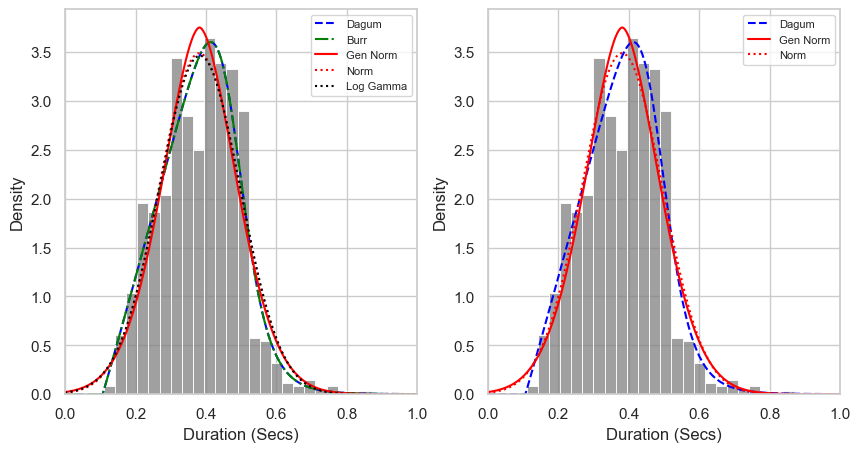

In [10]:
duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
params = []
for i, dist in enumerate(duration_dist): 
    params.append([dist, *f.fitted_param[dist]])

# Used to fit duration dataset (ALL)
x = np.linspace(0,1,500)
y = gennorm.pdf(x, params[0][1], params[0][2], params[0][3])   # for example#
gennorm_pdf = pd.DataFrame(y, columns=['Gen Norm'])
gennorm_pdf['x']=pd.DataFrame(x)

x = np.linspace(0,1,500)
y = norm.pdf(x, np.mean(main_data['duration_time_full']), np.std(main_data['duration_time_full']))   # for example#
norm_pdf = pd.DataFrame(y, columns=['Norm'])
norm_pdf['x']=pd.DataFrame(x)

from scipy.stats import fatiguelife, mielke, burr, loggamma, gamma
# x = np.linspace(0,1,500)
# y = fatiguelife.pdf(x, params[1][1], params[1][2], params[1][3])   # for example#
# fatiguelife_pdf = pd.DataFrame(y, columns=['Birnbaum–Saunders'])
# fatiguelife_pdf['x']=pd.DataFrame(x)

x = np.linspace(0,1,500)
y = mielke.pdf(x, params[2][1], params[2][2], params[2][3], params[2][4])   # for example#
mielke_pdf = pd.DataFrame(y, columns=['Dagum'])
mielke_pdf['x']=pd.DataFrame(x)

x = np.linspace(0,1,500)
y = burr.pdf(x, params[3][1], params[3][2], params[3][3], params[3][4])    # for example#
burr_pdf = pd.DataFrame(y, columns=['Burr'])
burr_pdf['x']=pd.DataFrame(x)

x = np.linspace(0,1,500)
y = loggamma.pdf(x, params[4][1], params[4][2], params[4][3])   # for example#
loggamma_pdf = pd.DataFrame(y, columns=['Log Gamma'])
loggamma_pdf['x']=pd.DataFrame(x)

# x = np.linspace(0,1,500)
# y = gamma.pdf(x, params[5][1], params[5][2], params[5][3])   # for example#
# gamma_pdf = pd.DataFrame(y, columns=['Gamma'])
# gamma_pdf['x']=pd.DataFrame(x)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot = sns.histplot(data=main_data, x="duration_time_full", stat='density', ax=ax, color="grey")
mielke_pdf.plot(x='x', y='Dagum', ax=ax, color='blue', style="--")
burr_pdf.plot(x='x', y='Burr', ax=ax, color='green', style="-.")
gennorm_pdf.plot(x='x', y='Gen Norm', ax=ax, color='red', style="-")
norm_pdf.plot(x='x', y='Norm', ax=ax, color='red', style=":")
loggamma_pdf.plot(x='x', y='Log Gamma', ax=ax, color='black', style=":")
ax.set_xlabel("Duration (Secs)"), ax.set_xlim([0, 1])
ax.set_ylabel("Density")
ax.legend(fontsize=8)

plot = sns.histplot(data=main_data, x="duration_time_full", stat='density', ax=ax2, color="grey")
mielke_pdf.plot(x='x', y='Dagum', ax=ax2, color='blue', style="--")
gennorm_pdf.plot(x='x', y='Gen Norm', ax=ax2, color='red', style="-")
norm_pdf.plot(x='x', y='Norm', ax=ax2, color='red', style=":")
ax2.set_xlabel("Duration (Secs)"), ax2.set_xlim([0, 1])
ax2.set_ylabel("Density")
ax2.legend(fontsize=8)
plt.savefig('5-Duration Fitting.png', bbox_inches='tight', dpi=400)
plt.show()

### Fitting distribution and parameters for each emotion group

In [11]:
params_emotions = []
for emotion in emotions: 
    temp = []
    test = main_data[main_data.emotion==emotion]['duration_time_full'].values
    f = Fitter(test, distributions=['mielke', 'norm', 'gennorm'], timeout=120)
    f.fit()
    temp.append(["mielke", *f.fitted_param["mielke"]])
    temp.append(["norm", *f.fitted_param["norm"]])
    temp.append(["gennorm", *f.fitted_param["gennorm"]])
    params_emotions.append([f"{emotion}", temp])

Fitting 3 distributions: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.58it/s]


### Exploring by datasets

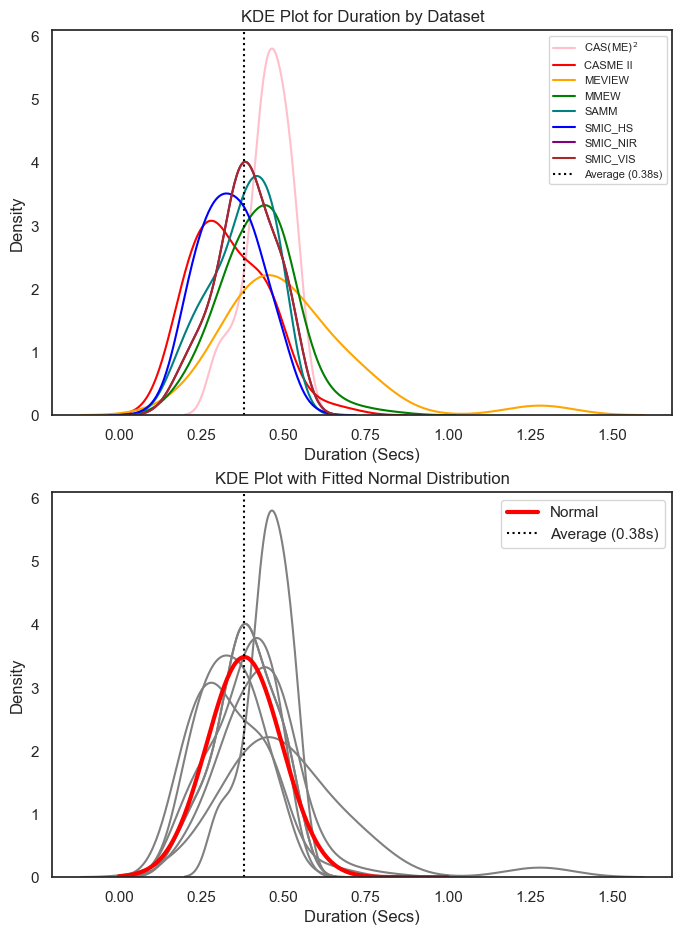

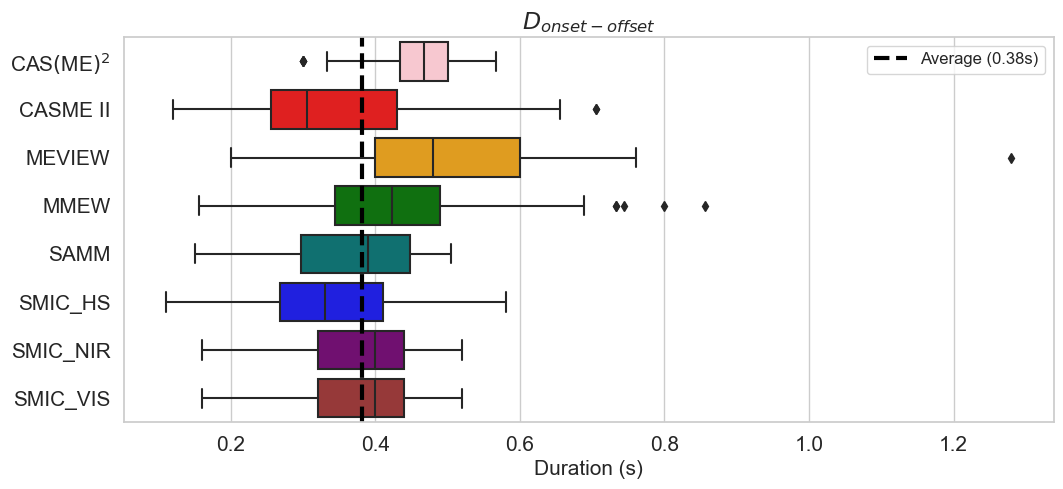

duration_time_full                                          \
                             count      mean       std       min       25%   
dataset                                                                      
CAS$($ME$)^{2}$               57.0  0.452632  0.066353  0.300000  0.433333   
CASME II                     255.0  0.336039  0.113039  0.120000  0.255000   
MEVIEW                        25.0  0.518400  0.211181  0.200000  0.400000   
MMEW                         300.0  0.421778  0.112253  0.155556  0.344444   
SAMM                         159.0  0.371855  0.094999  0.150000  0.297500   
SMIC_HS                      164.0  0.337317  0.092472  0.110000  0.267500   
SMIC_NIR                      71.0  0.384789  0.091055  0.160000  0.320000   
SMIC_VIS                      71.0  0.384789  0.091055  0.160000  0.320000   

                                               
                      50%       75%       max  
dataset                                        
CAS$($ME$)^{2}$  0.466667  0.500000  0.566667  
CASME II         0.305000  0.430000  0.705000  
MEVIEW           0.480000  0.600000  1.280000  
MMEW             0.422222  0.488889  0.855556  
SAMM             0.390000  0.447500  0.505000  
SMIC_HS          0.330000  0.410000  0.580000  
SMIC_NIR         0.400000  0.440000  0.520000  
SMIC_VIS         0.400000  0.440000  0.520000

In [12]:
# Remove outlier of 1.28 from dataset
#main_data.drop(main_data[main_data.duration_time_full==(np.max(main_data["duration_time_full"]))].index, inplace=True)
sns.set_theme(style="white")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 11))
for i in range(len(datasets)): 
    sns.kdeplot(data=main_data[main_data.dataset==datasets[i]].squeeze(), x="duration_time_full", ax=ax1, color=dataset_colors[i],
                      bw_method=0.5, label=datasets[i]).set_title('KDE Plot for Duration by Dataset')
    ax1.set_xlabel("Duration (Secs)"), ax1.set_ylabel("Density")
ax1.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='dotted', label='Average (0.38s)')
ax1.legend(fontsize=8)

plt.savefig('3-Microexpression Duration by Dataset.png')
for i in range(len(datasets)): 
    sns.kdeplot(data=main_data[main_data.dataset==datasets[i]].squeeze(), x="duration_time_full", ax=ax2, color='grey',
                      bw_method=0.5).set_title("KDE Plot with Fitted Normal Distribution")
    ax2.set_xlabel("Duration (Secs)"), ax2.set_ylabel("Density")


# Fit Normal Distribution
x = np.linspace(0,1,1000)
sample_mean = np.mean(main_data['duration_time_full'])
sample_std = np.std(main_data['duration_time_full'])
y = norm.pdf(x, sample_mean, sample_std)   
normal_dist = pd.DataFrame(y, columns=['Normal'])
normal_dist['x']=pd.DataFrame(x)
normal_dist.plot(x='x', y='Normal', ax=ax2, color='red', style='-', linewidth=3.0)
plt.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='dotted', label=f"Average ({np.mean(main_data['duration_time_full']):.2f}s)")
ax2.legend()
ax2.set_xlabel("Duration (Secs)"), ax2.set_ylabel("Density")
plt.show()


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(12,5))
test = sns.boxplot(data=main_data, x="duration_time_full", y="dataset",  
            ax=ax, palette=dataset_colors, order=datasets).set_title("$D_{onset-offset}$", fontsize=17)
ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='--', label=f"Average ({np.mean(main_data['duration_time_full']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=12)
plt.savefig('3-Microexpression Duration (Boxplot) by Dataset.png', bbox_inches='tight', dpi=400)
plt.show()

display(main_data[['dataset','duration_time_full']].groupby('dataset').describe())

### Exploring by Emotion Group

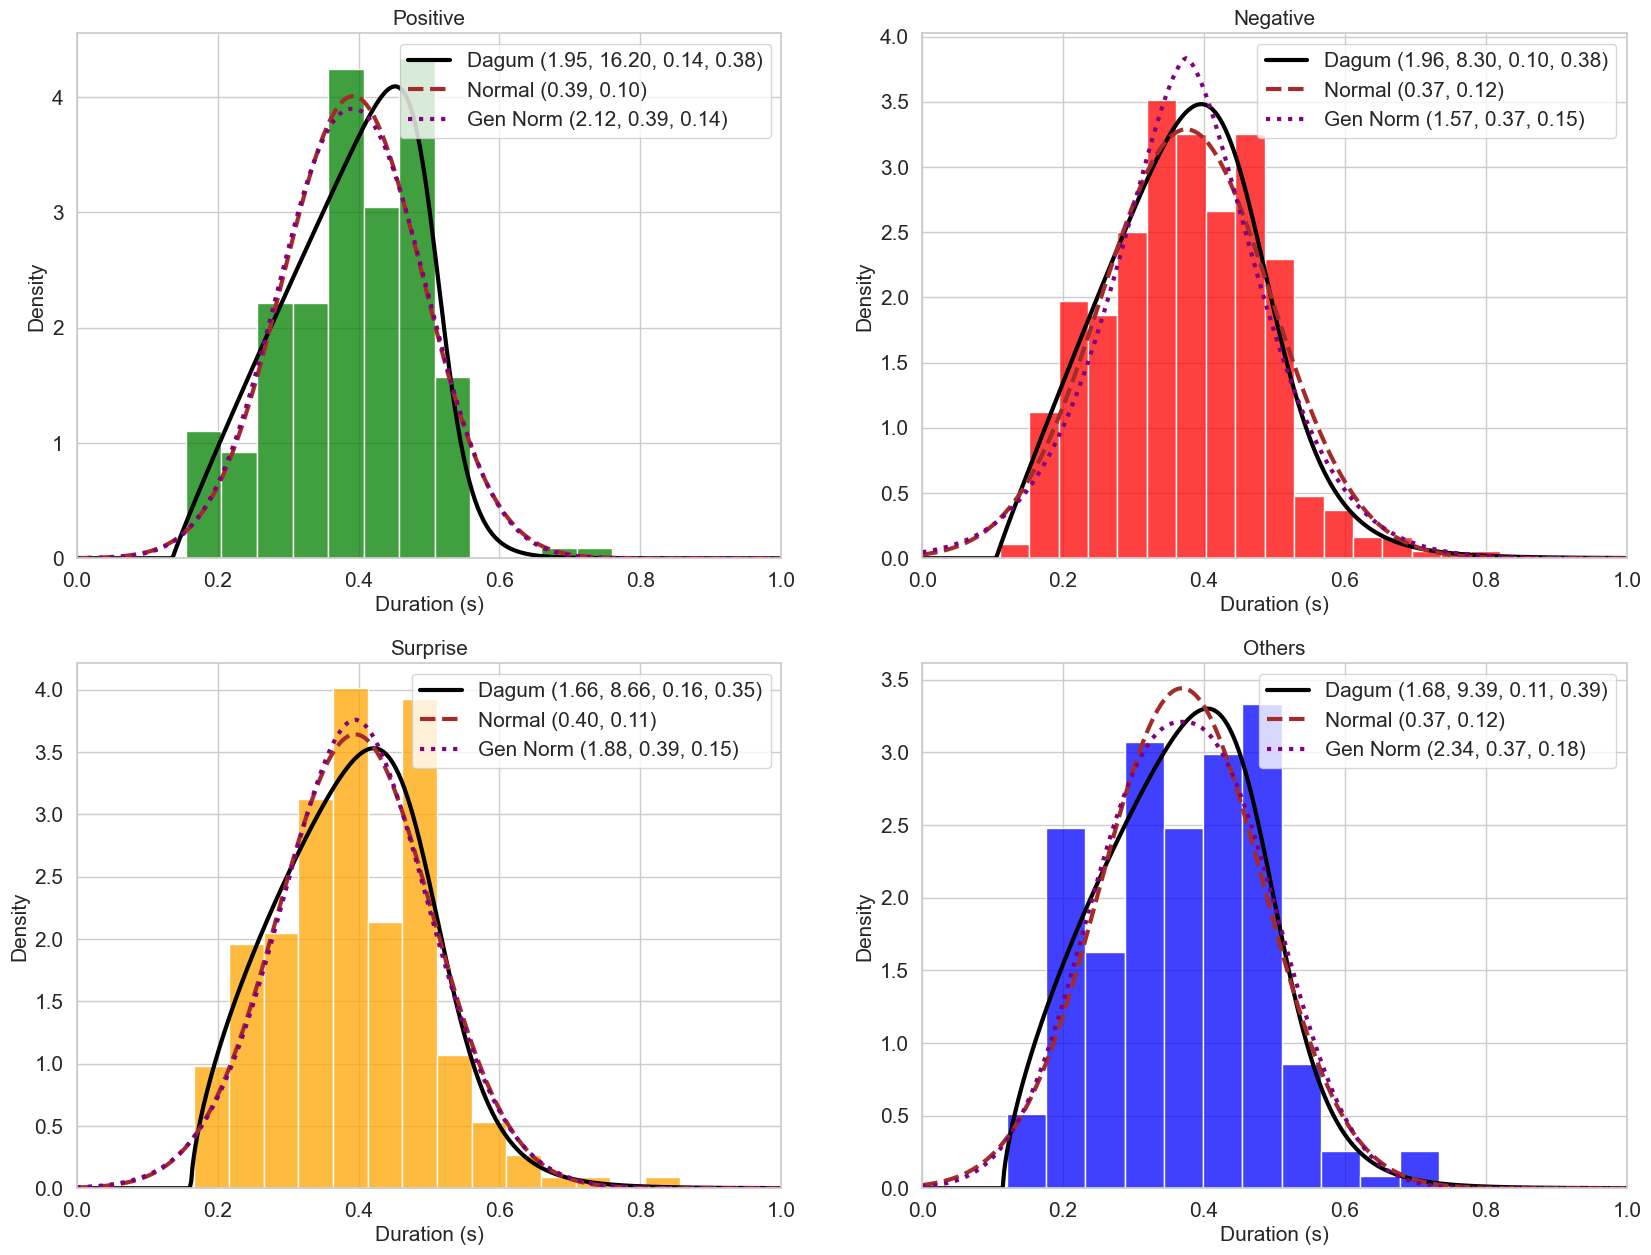

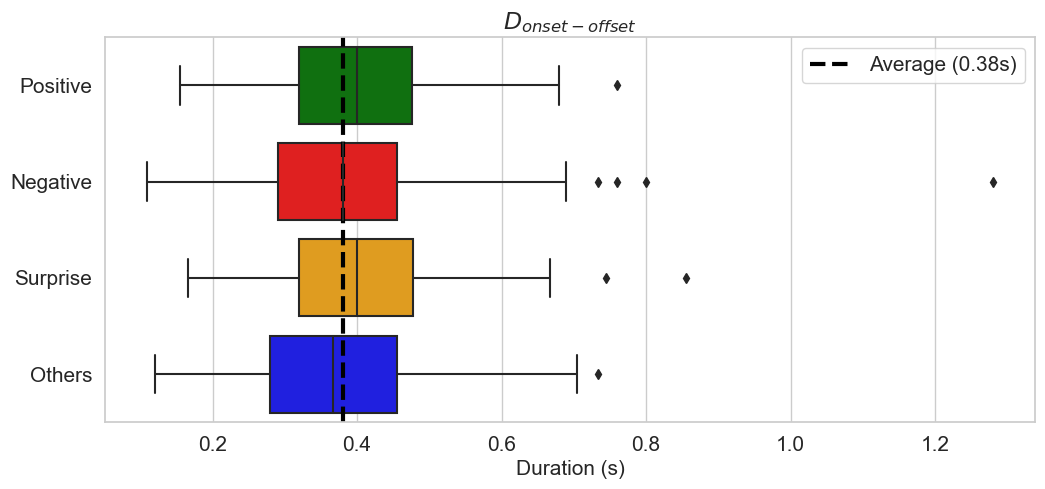

duration_time_full                                                \
                      count      mean       std       min   25%       50%   
emotion                                                                     
Negative              449.0  0.374761  0.121436  0.110000  0.29  0.380000   
Others                210.0  0.368717  0.116205  0.120000  0.28  0.366667   
Positive              215.0  0.392065  0.099793  0.155000  0.32  0.400000   
Surprise              228.0  0.395071  0.109807  0.166667  0.32  0.400000   

                              
               75%       max  
emotion                       
Negative  0.455000  1.280000  
Others    0.455000  0.733333  
Positive  0.476389  0.760000  
Surprise  0.477778  0.855556

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
i = 0 
for axe in axes:
    for ax in axe:
        test = sns.histplot(data=main_data[main_data.emotion==emotions[i]], x="duration_time_full", 
                    ax=ax, color=emotion_color[i], stat="density").set_title(f"{emotions[i].title()}", fontsize=15)
        x = np.linspace(0,1,500)
        y = norm.pdf(x, params_emotions[i][1][1][1], params_emotions[i][1][1][2])   # for example#
        norm_pdf = pd.DataFrame(y, columns=['Normal'])
        norm_pdf['x']=pd.DataFrame(x)

        x = np.linspace(0,1,500)
        y = mielke.pdf(x, params_emotions[i][1][0][1], params_emotions[i][1][0][2], params_emotions[i][1][0][3], params_emotions[i][1][0][4])   # for example#
        mielke_pdf = pd.DataFrame(y, columns=['Dagum'])
        mielke_pdf['x']=pd.DataFrame(x)
        
        x = np.linspace(0,1,500)
        y = gennorm.pdf(x, params_emotions[i][1][2][1], params_emotions[i][1][2][2],params_emotions[i][1][2][3])   # for example#
        gennorm_pdf = pd.DataFrame(y, columns=['Gen Norm'])
        gennorm_pdf['x']=pd.DataFrame(x)
        
        mielke_pdf.plot(x='x', y='Dagum', ax=ax, color='black', style="-", linewidth=3, 
                        label=f"Dagum ({params_emotions[i][1][0][1]:.2f}, {params_emotions[i][1][0][2]:.2f}, {params_emotions[i][1][0][3]:.2f}, {params_emotions[i][1][0][4]:.2f})")
        norm_pdf.plot(x='x', y='Normal', ax=ax, color='brown', style="--",linewidth=3, 
                      label=f"Normal ({params_emotions[i][1][1][1]:.2f}, {params_emotions[i][1][1][2]:.2f})")
        gennorm_pdf.plot(x='x', y='Gen Norm', ax=ax, color='purple', style=":",linewidth=3, 
                      label=f"Gen Norm ({params_emotions[i][1][2][1]:.2f}, {params_emotions[i][1][2][2]:.2f}, {params_emotions[i][1][2][3]:.2f})")
        ax.set_xlabel("Duration (s)", fontsize=15), ax.set_ylabel("Density", fontsize=15)
        ax.set_xlim([0, 1])
        ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
        i = i + 1
        ax.legend(fontsize=15, loc="upper right")
        
plt.savefig('4-Duration by emotion (histogram & fitted)', bbox_inches='tight', dpi=400)
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(12,5))
test = sns.boxplot(data=main_data, x="duration_time_full", y="emotion",  
            ax=ax, palette=emotion_color, order=emotions).set_title("$D_{onset-offset}$", fontsize=17)
ax.set_xlabel("Duration (s)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15), ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(x=np.mean(main_data['duration_time_full']), color='black', ls='--', label=f"Average ({np.mean(main_data['duration_time_full']):.2f}s)", linewidth=3.0)
ax.legend(fontsize=15, loc="upper right")
ax.set_ylabel("")
plt.savefig('4-Duration by emotion (boxplot)', bbox_inches='tight', dpi=400)
plt.show()

temp = main_data[['emotion','duration_time_full']].groupby('emotion').describe()
display(main_data[['emotion','duration_time_full']].groupby('emotion').describe())

In [15]:
duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
duration_fit = main_data['duration_time_full'].values
f = Fitter(duration_fit, distributions=duration_dist, timeout=300)
f.fit()
temp = f.summary(plot=False)
display(temp)

duration_dist = ['gennorm', 'fatiguelife', 'mielke', 'burr', 'loggamma', 'norm']
duration_fit = main_data2['duration_time_full'].values
f1 = Fitter(duration_fit, distributions=duration_dist, timeout=300)
f1.fit()
temp = f1.summary(plot=False)
display(temp)

duration_dist = ['mielke', 'norm', 'gennorm']
params_all = []
for i, dist in enumerate(duration_dist): 
    params_all.append([dist, *f.fitted_param[dist]])
    

params_exc = []
for i, dist in enumerate(duration_dist): 
    params_exc.append([dist, *f1.fitted_param[dist]])

Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.65it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,27.250014,674.878338,-4049.190870,inf,0.034652,0.138500
burr,27.250085,674.878627,-4049.188006,inf,0.034653,0.138476
loggamma,29.819198,1425.388495,-3956.907358,inf,0.050724,0.006647
norm,30.014423,1378.703765,-3956.720995,inf,0.048930,0.009874
gennorm,31.804636,1086.612025,-3885.872795,inf,0.047822,0.012517


Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.53it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,138.514003,258.769512,-2086.947140,inf,0.038303,0.090528
burr,138.514038,258.766064,-2086.946874,inf,0.038304,0.090513
gennorm,146.547490,318.923688,-2034.928357,inf,0.058947,0.001334
loggamma,148.116996,283.655937,-2023.785389,inf,0.059386,0.001196
norm,148.721161,274.079778,-2026.480187,inf,0.061099,0.000775


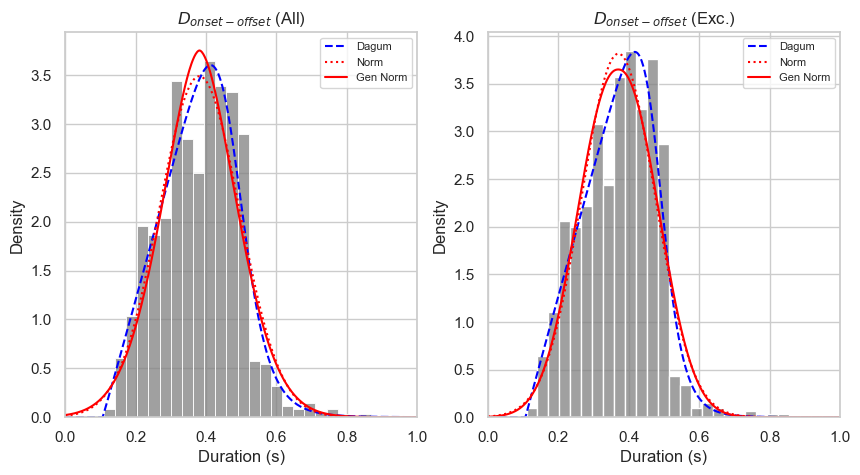

In [16]:
params = params_all.copy()
x = np.linspace(0,1,500)
y = mielke.pdf(x, params[0][1], params[0][2], params[0][3], params[0][4])   # for example#
mielke_pdf = pd.DataFrame(y, columns=['Dagum'])
mielke_pdf['x']=pd.DataFrame(x)

y = norm.pdf(x, params[1][1], params[1][2])   # for example#
norm_pdf = pd.DataFrame(y, columns=['Norm'])
norm_pdf['x']=pd.DataFrame(x)

y = gennorm.pdf(x, params[2][1], params[2][2], params[2][3])   # for example#
gennorm_pdf = pd.DataFrame(y, columns=['Gen Norm'])
gennorm_pdf['x']=pd.DataFrame(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot = sns.histplot(data=main_data, x="duration_time_full", stat='density', ax=ax1, color="grey").set_title("$D_{onset-offset}$ (All)")
mielke_pdf.plot(x='x', y='Dagum', ax=ax1, color='blue', style="--")
norm_pdf.plot(x='x', y='Norm', ax=ax1, color='red', style=":")
gennorm_pdf.plot(x='x', y='Gen Norm', ax=ax1, color='red', style="-")
ax1.set_xlabel("Duration (s)"), ax1.set_xlim([0, 1])
ax1.set_ylabel("Density")
ax1.legend(fontsize=8)
# Used to fit duration dataset (ALL)

params = params_exc.copy()
x = np.linspace(0,1,500)
y = mielke.pdf(x, params[0][1], params[0][2], params[0][3], params[0][4])   # for example#
mielke_pdf = pd.DataFrame(y, columns=['Dagum'])
mielke_pdf['x']=pd.DataFrame(x)

y = norm.pdf(x, params[1][1], params[1][2])   # for example#
norm_pdf = pd.DataFrame(y, columns=['Norm'])
norm_pdf['x']=pd.DataFrame(x)

y = gennorm.pdf(x, params[2][1], params[2][2], params[2][3])   # for example#
gennorm_pdf = pd.DataFrame(y, columns=['Gen Norm'])
gennorm_pdf['x']=pd.DataFrame(x)

plot = sns.histplot(data=main_data2, x="duration_time_full", stat='density', ax=ax2, color="grey").set_title("$D_{onset-offset}$ (Exc.)")
mielke_pdf.plot(x='x', y='Dagum', ax=ax2, color='blue', style="--")
norm_pdf.plot(x='x', y='Norm', ax=ax2, color='red', style=":")
gennorm_pdf.plot(x='x', y='Gen Norm', ax=ax2, color='red', style="-")
ax2.set_xlabel("Duration (s)"), ax2.set_xlim([0, 1])
ax2.set_ylabel("Density")
ax2.legend(fontsize=8)
plt.savefig('5-Duration Fitting (both).png', bbox_inches='tight', dpi=400)
plt.show()

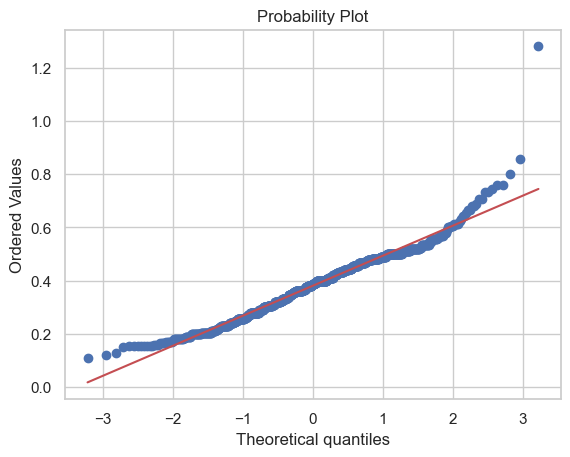

In [17]:
import pylab
test = stats.probplot(main_data['duration_time_full'], dist="norm", plot=pylab)
plt.savefig('6-QQ Plot.png', bbox_inches='tight', dpi=400)
pylab.show()

In [18]:
from scipy.stats import shapiro
stat, p = shapiro(main_data['duration_time_full'])
print('stat=%.3f, p=%.3f\n' % (stat, p))

# not a normal distribution

from scipy.stats import shapiro
temp = main_data.copy()
temp['duration_time_full'] = (temp['duration_time_full']- np.mean(temp["duration_time_full"]))/np.std(temp["duration_time_full"])
stat, p = shapiro(temp['duration_time_full'])
print('stat=%.3f, p=%.5f\n' % (stat, p))

from scipy.stats import normaltest
stat, p = normaltest(main_data['duration_time_full'])
print('stat=%.3f, p=%.3f\n' % (stat, p))

stat=0.966, p=0.000

stat=0.966, p=0.00000

stat=148.598, p=0.000



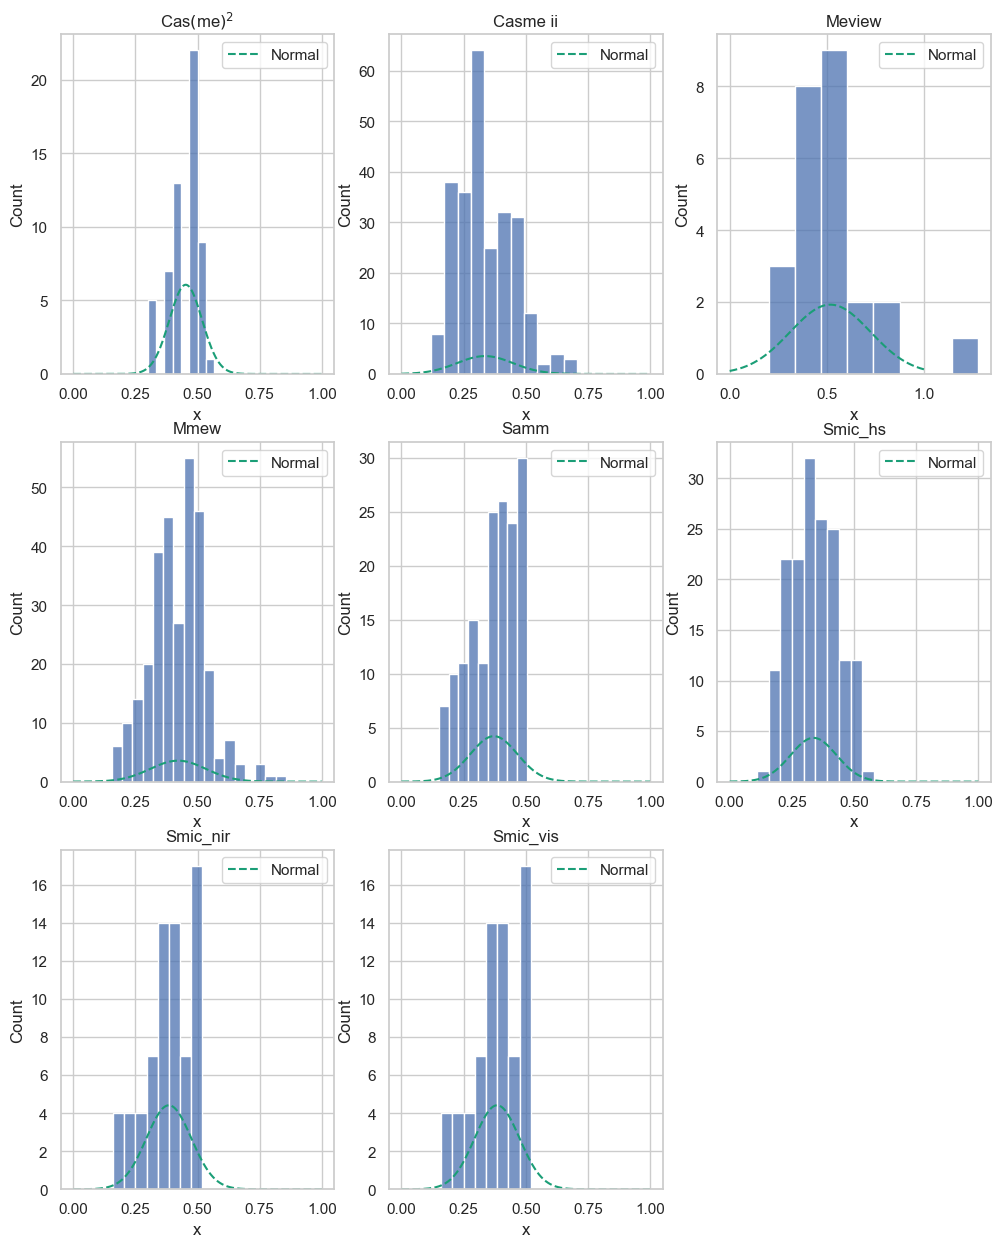

In [19]:
f, ax = plt.subplots(3, 3, figsize=(12, 15))
f.delaxes(ax[2,2]) #The indexing is zero-based here
i = 0
for j, axes in enumerate(ax):
    for ax in axes:
        sns.histplot(main_data[main_data.dataset==datasets[i]]['duration_time_full'], ax=ax).set_title(datasets[i].capitalize())
        x = np.linspace(0,1,1000)
        sample_mean = np.mean(main_data[main_data.dataset==datasets[i]]['duration_time_full'])
        sample_var = np.var(main_data[main_data.dataset==datasets[i]]['duration_time_full'])
        sample_std = np.std(main_data[main_data.dataset==datasets[i]]['duration_time_full'])
        y = norm.pdf(x, sample_mean, sample_std)   # for example#
        test = pd.DataFrame(y, columns=['Normal'])
        test['x']=pd.DataFrame(x)
        test.plot(x='x', y='Normal', ax=ax, colormap='Dark2', style='--')

        i = i + 1
        if i == len(datasets):
            break 
plt.show()
        